In [201]:
import torch
from torch import nn # neural networks building blocks
import numpy as np
import matplotlib.pyplot as plt

In [202]:
torch.__version__

'2.0.1+cu118'

In [203]:
# data prep and load
weight = 0.7 # a
bias = 0.3 # b

# create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # size = (50, 1)
y = weight * X + bias # linear regression formula (y = ax + b)

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [204]:
len(X), len(y)

(50, 50)

In [205]:
# split data: training set, test set, validation set
# 80/20 train/test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [206]:
# visualize our X data
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
    Plots training/test data and compares predictions.
  """
  plt.figure(figsize=(5, 3)) # other (10, 7)
  # Plot taining data in magenta
  plt.scatter(train_data, train_labels, c="m", s=4, label="Training data")
  # Plot test data in black
  plt.scatter(test_data, test_labels, c="k", s=4, label="Testing data")

  if predictions is not None:
    # Plot prediction in blue
    plt.scatter(test_data, predictions, c="b", s=4, label="Predictions")

  # add legend
  plt.legend(prop={"size":9}) #font size is 9


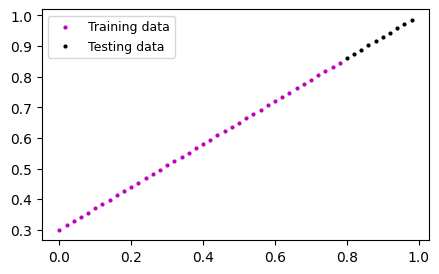

In [207]:
plot_prediction()

In [208]:
# build a linear regression model
# nn.Parameter, what parameters our model should learn
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # gradiant descent
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True, # gradiant descent
                                         dtype=torch.float))
  # defines the computation in the model
  # required from nn.Model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.weights * x + self.bias

In [209]:
# create a random seed
torch.manual_seed(42)
# create an instance of the model
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [210]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [211]:
# making predictions via torch.inference_mode()
with torch.inference_mode(): # context manager, doesn't track the gradient since we are just testing
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [212]:
# previous version of torch.inference_mode()
# does not track the gradient during inference/testing
with torch.no_grad():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

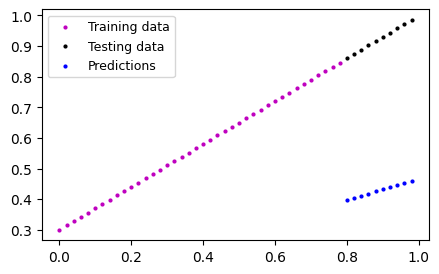

In [213]:
plot_prediction(predictions=y_preds)

In [214]:
# loss function/ cost function / criterion -- all the same concept!, It measures how poor the model predictions are with respect to the ideal outputs
loss_fn = nn.L1Loss() # Mean Absolute Error avg(abs(x-x0))

# Optimizer - take into account the loss and adjusts the model's parameters (weight, bias) to improve/minimize loss
# Stocatic Gradient Descent
optimizer = torch.optim.SGD(model_0.parameters(), # the model paramters
                            0.01) # learning rate - the step with which the bias/weight will change

In [215]:
# Training/Testing Loop
# 0. loop through the data
# 1. forward pass/propagation: from input to the output, make predictions
# 2. calculate the loss (predictions vs ground truth)
# 3. optimizer zero grad
# 4. loss backward - move backwards through the network to compute the gradients of each of the paramenters of our model wrt the loss
# 5. optimizer step - adjust model parameters to improve loss

torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 165
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # sets all parameters that need a gradient

  # 1. forward
  y_pred = model_0(X_train)

  # 2. calculate the loss function
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad() # start fresh, every epoch

  # 4. loss backward, backpropagation on the loss function (computes the gradient of every parameter with requires_grad=True)
  loss.backward()

  # 5. optimizer step SGD, update the parameters
  optimizer.step()

  ### Testing
  model_0.eval() # turns off settings not needed in testing
  with torch.inference_mode(): # the gradient tracking
    # 0. do the forward pass
    test_pred = model_0(X_test)
    # 1. compute test loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

    # print weights/bias update
    print(model_0.state_dict())

Epoch: 0 | Train Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Train Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Train Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Train Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Train Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Train Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Train Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', 

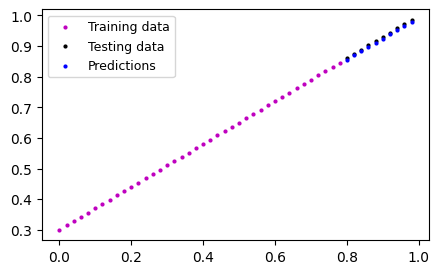

In [216]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_prediction(predictions=y_preds_new)